# Lab 2 (Part 2): Regularizing MLPs

**Jose Antonio Jijon Vorbeck - 100438045**

------------------------------------------------------
*Deep Learning. Master in Big Data Analytics*

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this second part of the lab, we'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping, dropout, and L2 weight regularization.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Lets take a look to the mini-batch size and plot a sample.

In [ ]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

Digit associated to this is: 1


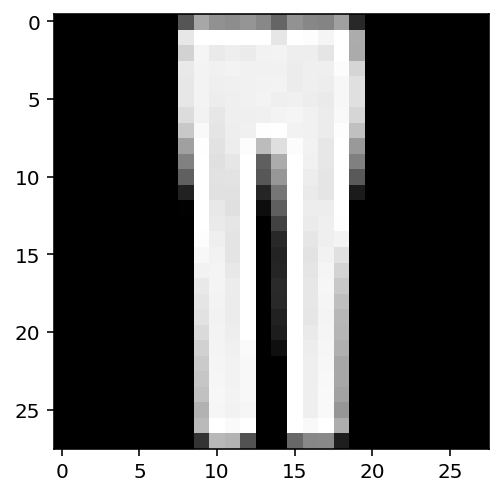

In [ ]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')
print(f'Digit associated to this is: {labels[1].item()}')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and evaluate train/test performance

In [ ]:
# Creating the NN class
class MLP(nn.Module):
    def __init__(self, dimx, nlabels, hidden1=256, hidden2=128, hidden3=64):
        super().__init__()
  
        # first layer
        self.output1 = nn.Linear(dimx,hidden1)
        # second layer
        self.output2 = nn.Linear(hidden1, hidden2)
        # third layer
        self.output3 = nn.Linear(hidden2, hidden3)
        # fourth layer
        self.output4 = nn.Linear(hidden3, nlabels)
  
        # ReLu activation function
        self.relu = nn.ReLU()
        # log-softmax activation fun.
        self.logsoft = nn.LogSoftmax(dim=1)


    def forward(self, x):

        # first layer
        x = self.relu(self.output1(x))
        # second layer
        x = self.relu(self.output2(x))
        # third layer
        x = self.relu(self.output3(x))
        # fourth layer
        x = self.logsoft(self.output4(x))
        return x

In [ ]:
# Now we create the class that we will use for training and testing
class MLP_extended(MLP):
    def __init__(self, dimx, nlabels, hidden1=256, hidden2=128, hidden3=64, epochs=30, lr = 1e-3):
        super().__init__(dimx, nlabels, hidden1=256, hidden2=128, hidden3=64)
    
        # attributes:
    
        self.lr = lr        # learning rate
        self.optim = optim.Adam(self.parameters(), self.lr)   #optimizer
        self.epochs = epochs    # epochs
        self.criterion = nn.NLLLoss()

        # create a list to store the loss at each epoch:
        self.loss_during_training = []

    def trainloop(self, loader):

          # optimization loop

        for j in range(int(self.epochs)):   # looping for all the epochs

            # making the error equal to zero:
            running_loss = 0

            for images, labels in loader:

                self.optim.zero_grad()

                # get output of value:
                out = self.forward(images.view(images.shape[0], -1))

                # computing the loss
                loss = self.criterion(out, labels)

                # adding up to the running loss
                running_loss += loss.item()
                loss.backward()
                # changing the parameters with the optimizer:
                self.optim.step()


            # appending the avg. running_loss to the epoch error list:
            self.loss_during_training.append(running_loss/len(trainloader))

            # printing the errors:
            if(j % 10 == 0):
                print(f'Training Loss after {j} epochs: {self.loss_during_training[-1]}')


    def accuracy(self, loader, part):

        accuracy = 0

        with torch.no_grad():

          for images, labels in loader:

            logprobs = self.forward(images.view(images.shape[0], -1))
            top_p, top_class = logprobs.topk(1, dim=1)

            equals = (top_class == labels.view(images.shape[0], -1))

            accuracy += torch.mean(equals.type(torch.FloatTensor))

        # printing the accuracy: 

        print(f'The accuracy in the {part} dataset is: {accuracy/len(loader)}')


In [ ]:
#YOUR CODE HERE
# training and evaluating the model:
dimx = 28*28
my_MLP = MLP_extended(dimx, 10)
# train the model
my_MLP.trainloop(trainloader)

Training Loss after 0 epochs: 0.5227527167560704
Training Loss after 10 epochs: 0.2186413343940208
Training Loss after 20 epochs: 0.15034523246480203


In [ ]:
# training accuracy
my_MLP.accuracy(trainloader, 'training')
# testing accuracy
my_MLP.accuracy(testloader, 'testing')

The accuracy in the training dataset is: 0.9643356800079346
The accuracy in the testing dataset is: 0.8887341022491455


In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [ ]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]



> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs. Compute the final train/validation/test performance.

In [ ]:
#YOUR CODE HERE

# Now add the computation of the loss with respect to the validation set
class MLP_extended2(MLP):
    def __init__(self, dimx, nlabels, hidden1=256, hidden2=128, hidden3=64, epochs=30, lr = 1e-3):
        super().__init__(dimx, nlabels, hidden1=256, hidden2=128, hidden3=64)
    
        # attributes:
    
        self.lr = lr        # learning rate
        self.optim = optim.Adam(self.parameters(), self.lr)   #optimizer
        self.epochs = epochs    # epochs
        self.criterion = nn.NLLLoss()

        # create a list to store the loss at each epoch:
        self.loss_during_training = []

        # create a list to store the loss over validation:
        self.valid_loss_during_training = []

    def trainloop(self, trainloader, validloader):

          # optimization loop

        for j in range(int(self.epochs)):   # looping for all the epochs

            # making the error equal to zero:
            running_loss = 0
            valid_loss = 0

            for images, labels in trainloader:

                self.optim.zero_grad()

                # get output of value:
                out = self.forward(images.view(images.shape[0], -1))

                # computing the loss
                loss = self.criterion(out, labels)

                # adding up to the running loss
                running_loss += loss.item()
                loss.backward()
                # changing the parameters with the optimizer:
                self.optim.step()

            
            # computation of the loss w.r.t the validation:
            with torch.no_grad():

              for images_valid, labels_valid in validloader:

                out_valid = self.forward(images_valid.view(images_valid.shape[0], -1))

                loss_valid = self.criterion(out_valid, labels_valid)

                valid_loss += loss_valid

            # appending the avg. running_loss to the epoch error list:
            self.loss_during_training.append(running_loss/len(trainloader))
            # appending the validation loss
            self.valid_loss_during_training.append(valid_loss/len(validloader))

            # printing the errors for both training and validation datasets:
            if(j % 5 == 0):
                print(f'Training Loss after {j} epochs: {self.loss_during_training[-1]}')
                print(f'Validation Loss after {j} epochs: {self.valid_loss_during_training[-1]}')




    def accuracy(self, loader, part='Training'):

        accuracy = 0

        with torch.no_grad():

          for images, labels in loader:

            logprobs = self.forward(images.view(images.shape[0], -1))
            top_p, top_class = logprobs.topk(1, dim=1)

            equals = (top_class == labels.view(images.shape[0], -1))

            accuracy += torch.mean(equals.type(torch.FloatTensor))

        # printing the accuracy: 

        print(f'The accuracy in the {part} dataset is: {accuracy/len(loader)}')



In [ ]:
# now we train and implement the new method:

my_mlp = MLP_extended2(dimx, 10)
my_mlp.trainloop(trainloader, validloader)

Training Loss after 0 epochs: 0.5440986867232079
Validation Loss after 0 epochs: 0.4118369519710541
Training Loss after 5 epochs: 0.28982503241224383
Validation Loss after 5 epochs: 0.3415098190307617
Training Loss after 10 epochs: 0.22652374262477018
Validation Loss after 10 epochs: 0.329180508852005
Training Loss after 15 epochs: 0.18169970120321854
Validation Loss after 15 epochs: 0.3516446650028229
Training Loss after 20 epochs: 0.14814237852856008
Validation Loss after 20 epochs: 0.3994126617908478
Training Loss after 25 epochs: 0.12133623772057366
Validation Loss after 25 epochs: 0.439168244600296


In [ ]:
plt.plot(my_mlp.loss_during_training)
plt.plot(my_mlp.valid_loss_during_training)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Errors during training')
plt.show()

In [ ]:
# now we get the performances of all datasets:
my_mlp.accuracy(trainloader, 'training')
my_mlp.accuracy(validloader, 'validation')
my_mlp.accuracy(testloader, 'testing')

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

In [ ]:
#YOUR CODE HERE
# get the epoch that has the lowest validation loss:
epoch = my_mlp.valid_loss_during_training.index(min(my_mlp.valid_loss_during_training)) + 1 # subtract 1 because of the index

# now we train the model with only that number of epochs:
my_mlp2 = MLP_extended2(dimx, 10, epochs=epoch)
my_mlp2.trainloop(trainloader, validloader)

Training Loss after 0 epochs: 0.5527474085736851
Validation Loss after 0 epochs: 0.4212166965007782
Training Loss after 5 epochs: 0.29019215573895385
Validation Loss after 5 epochs: 0.3700103163719177


In [ ]:
# now we see the performance of each case:
my_mlp2.accuracy(trainloader, 'training')
my_mlp2.accuracy(validloader, 'validation')
my_mlp2.accuracy(testloader, 'testing')

The accuracy in the training dataset is: 0.9161710143089294
The accuracy in the validation dataset is: 0.8859707713127136
The accuracy in the testing dataset is: 0.8771895170211792


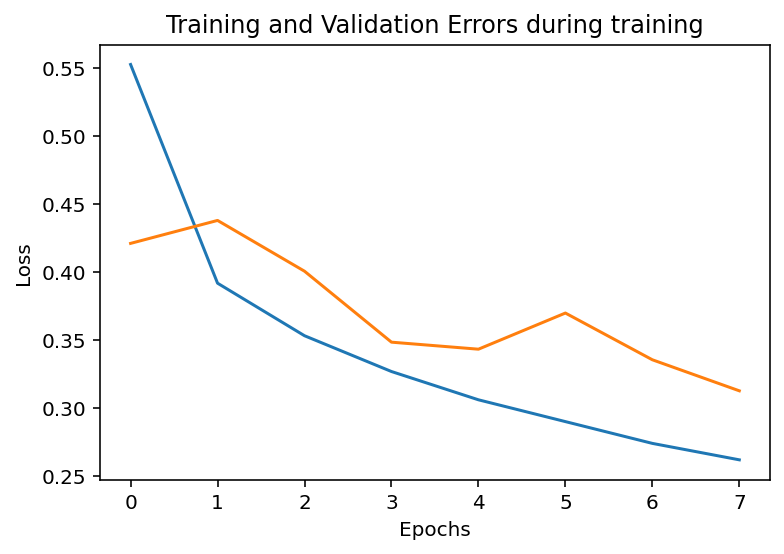

In [ ]:
plt.plot(my_mlp2.loss_during_training)
plt.plot(my_mlp2.valid_loss_during_training)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Errors during training')
plt.show()

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modified the extended clases to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [88]:
# new model applying the dropout option to avoid overfitting
class MLPdrop(nn.Module):
    def __init__(self, dimx, nlabels, hidden1=256, hidden2=128, hidden3=64, pr=0.2):
        super().__init__()
  
        # first layer
        self.output1 = nn.Linear(dimx,hidden1)
        # second layer
        self.output2 = nn.Linear(hidden1, hidden2)
        # third layer
        self.output3 = nn.Linear(hidden2, hidden3)
        # fourth layer
        self.output4 = nn.Linear(hidden3, nlabels)
  
        # ReLu activation function
        self.relu = nn.ReLU()
        # log-softmax activation fun.
        self.logsoft = nn.LogSoftmax(dim=1)

        # Dropout method
        self.dropout = nn.Dropout(p=pr)


    def forward(self, x):

        # first layer
        x = self.relu(self.output1(x))
        # apply dropout method
        x = self.dropout(x)
        # second layer
        x = self.relu(self.output2(x))
        # apply dropout method
        x = self.dropout(x)
        # third layer
        x = self.relu(self.output3(x))
        # apply dropout method
        x = self.dropout(x)
        # fourth layer
        x = self.logsoft(self.output4(x))
        return x

In [98]:
class MLPdrop_extended(MLPdrop):
    def __init__(self, dimx, nlabels, hidden1=256, hidden2=128, hidden3=64, pr = 0.2, epochs=30, lr = 1e-3):
        super().__init__(dimx, nlabels, hidden1=hidden1, hidden2=hidden2, hidden3=hidden3, pr=pr)
    
        # attributes:
    
        self.lr = lr        # learning rate
        self.optim = optim.Adam(self.parameters(), self.lr)   #optimizer
        self.epochs = epochs    # epochs
        self.criterion = nn.NLLLoss()

        # create a list to store the loss at each epoch:
        self.loss_during_training = []

        # create a list to store the loss over validation:
        self.valid_loss_during_training = []

    def trainloop(self, trainloader, validloader):

      # setting training mode on

        # optimization loop

        for j in range(int(self.epochs)):   # looping for all the epochs

            # making the error equal to zero:
            running_loss = 0.
            valid_loss = 0.

            for images, labels in trainloader:

                self.optim.zero_grad()
                self.train()

                # get output of value:
                out = self.forward(images.view(images.shape[0], -1))

                # computing the loss
                loss = self.criterion(out, labels)

                # adding up to the running loss
                running_loss += loss.item()
                loss.backward()
                # changing the parameters with the optimizer:
                self.optim.step()

            
            # computation of the loss w.r.t the validation:
            with torch.no_grad():

              self.eval()

              for images_valid, labels_valid in validloader:

                out_valid = self.forward(images_valid.view(images_valid.shape[0], -1))

                loss_valid = self.criterion(out_valid, labels_valid)

                valid_loss += loss_valid

            self.train()

            # appending the avg. running_loss to the epoch error list:
            self.loss_during_training.append(running_loss/len(trainloader))
            # appending the validation loss
            self.valid_loss_during_training.append(valid_loss/len(validloader))

            # printing the errors for both training and validation datasets:
            if(j % 5 == 0):
                print(f'Training Loss after {j} epochs: {self.loss_during_training[-1]}')
                print(f'Validation Loss after {j} epochs: {self.valid_loss_during_training[-1]}')




    def accuracy(self, loader, part='Training'):

      # setting evaluation mode on:
        self.eval()

        accuracy = 0

        with torch.no_grad():

          for images, labels in loader:

            logprobs = self.forward(images.view(images.shape[0], -1))
            top_p, top_class = logprobs.topk(1, dim=1)

            equals = (top_class == labels.view(images.shape[0], -1))

            accuracy += torch.mean(equals.type(torch.FloatTensor))

        self.accu = accuracy/len(loader)

        # printing the accuracy: 

        print(f'The accuracy in the {part} dataset is: {self.accu}')
        return self.accu



Now we will analyize this method plotting the training and validation loss scores during training

In [94]:
mlp_drop = MLPdrop_extended(dimx, 10, pr = 0.2)
mlp_drop.trainloop(trainloader, validloader)

Training Loss after 0 epochs: 0.6453288567083125
Validation Loss after 0 epochs: 0.45299968123435974
Training Loss after 5 epochs: 0.3541334473993629
Validation Loss after 5 epochs: 0.36842992901802063
Training Loss after 10 epochs: 0.3060508081795309
Validation Loss after 10 epochs: 0.3443754017353058
Training Loss after 15 epochs: 0.2738312553000552
Validation Loss after 15 epochs: 0.3275904357433319
Training Loss after 20 epochs: 0.25203285145107657
Validation Loss after 20 epochs: 0.33536118268966675
Training Loss after 25 epochs: 0.23323547171788628
Validation Loss after 25 epochs: 0.3344140350818634


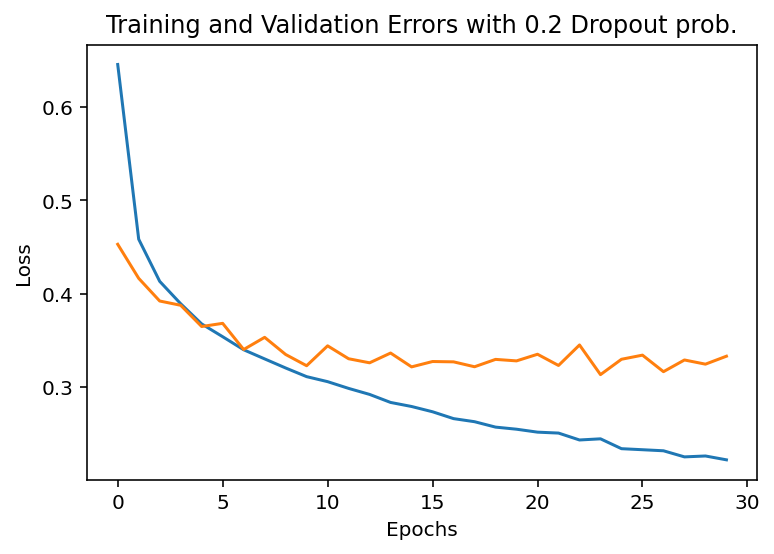

In [95]:
# plotting the training and validation training_losses
plt.plot(mlp_drop.loss_during_training)
plt.plot(mlp_drop.valid_loss_during_training)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Errors with 0.2 Dropout prob.')
plt.show()

In [96]:
# getting the accuracies of each of the datasets:
acc_02_training       = mlp_drop.accuracy(trainloader, 'training')
acc_02_validation = mlp_drop.accuracy(validloader, 'validation')
acc_02_testing    = mlp_drop.accuracy(testloader, 'Testing')

The accuracy in the training dataset is: 0.9349920153617859
The accuracy in the validation dataset is: 0.8919326663017273
The accuracy in the Testing dataset is: 0.8843550682067871


In [99]:
Performance_02 = {'Training': acc_02_training.item(), 'Validating': acc_02_validation.item(), 'Testing': acc_02_testing.item()}

Now we repeat the process but with dropout probablity of 0.1 and 0.3

**Dropout Probability 0.1**

In [100]:
# instantiate and train the model
mlp_drop1 = MLPdrop_extended(dimx, 10, pr = 0.1)
mlp_drop1.trainloop(trainloader, validloader)

Training Loss after 0 epochs: 0.5998896992426704
Validation Loss after 0 epochs: 0.4376060664653778
Training Loss after 5 epochs: 0.3193197828315368
Validation Loss after 5 epochs: 0.33498522639274597
Training Loss after 10 epochs: 0.2629936729896475
Validation Loss after 10 epochs: 0.3294782042503357
Training Loss after 15 epochs: 0.23033836105076427
Validation Loss after 15 epochs: 0.3305032551288605
Training Loss after 20 epochs: 0.20418958315117794
Validation Loss after 20 epochs: 0.352048397064209
Training Loss after 25 epochs: 0.18643437905649823
Validation Loss after 25 epochs: 0.3500632643699646


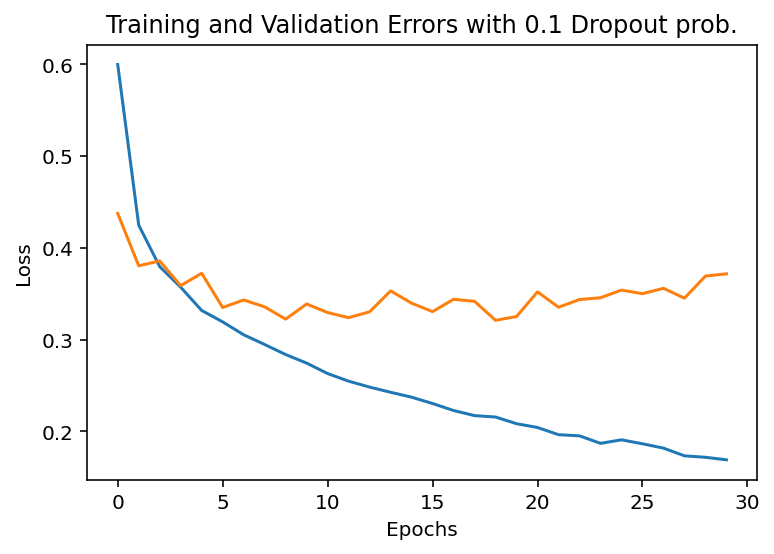

In [101]:
# plotting the training and validation training_losses
plt.plot(mlp_drop1.loss_during_training)
plt.plot(mlp_drop1.valid_loss_during_training)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Errors with 0.1 Dropout prob.')
plt.show()

In [102]:
acc_01_training   = mlp_drop1.accuracy(trainloader, 'training')
acc_01_validation = mlp_drop1.accuracy(validloader, 'validation')
acc_01_testing    = mlp_drop1.accuracy(testloader, 'testing')

The accuracy in the training dataset is: 0.9501065611839294
The accuracy in the validation dataset is: 0.8930186033248901
The accuracy in the testing dataset is: 0.8889331221580505


In [103]:
Performance_01 = {'Training': acc_01_training.item(), 'Validating': acc_01_validation.item(), 'Testing': acc_01_testing.item()}

**Dropout Probability 0.3**

In [104]:
# instantiate and train the model
mlp_drop3 = MLPdrop_extended(dimx, 10, pr = 0.3)
mlp_drop3.trainloop(trainloader, validloader)

Training Loss after 0 epochs: 0.6951789524914189
Validation Loss after 0 epochs: 0.4561971127986908
Training Loss after 5 epochs: 0.38696790852753277
Validation Loss after 5 epochs: 0.3656851053237915
Training Loss after 10 epochs: 0.34143743109466
Validation Loss after 10 epochs: 0.336431086063385
Training Loss after 15 epochs: 0.3139994402352551
Validation Loss after 15 epochs: 0.3269636332988739
Training Loss after 20 epochs: 0.2910950188419189
Validation Loss after 20 epochs: 0.3285420835018158
Training Loss after 25 epochs: 0.2794605693938634
Validation Loss after 25 epochs: 0.3114241659641266


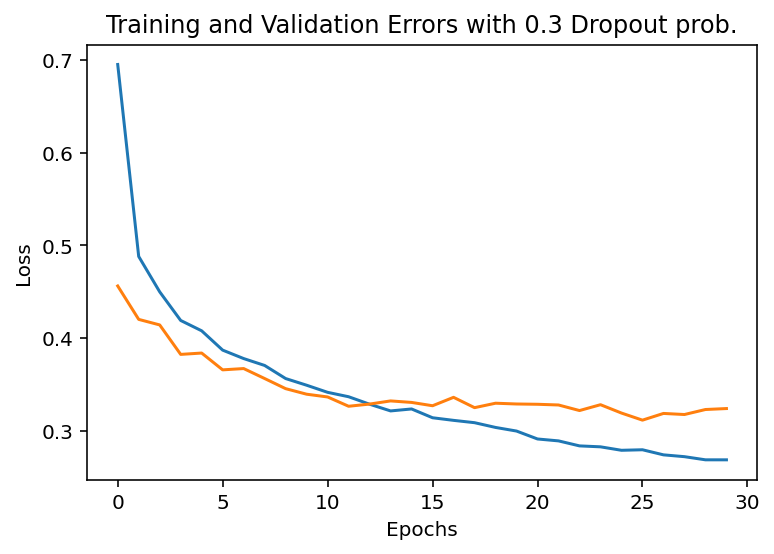

In [105]:
# plotting the training and validation training_losses
plt.plot(mlp_drop3.loss_during_training)
plt.plot(mlp_drop3.valid_loss_during_training)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Errors with 0.3 Dropout prob.')
plt.show()

In [106]:
acc_03_training   = mlp_drop3.accuracy(trainloader, 'training')
acc_03_validation = mlp_drop3.accuracy(validloader, 'validation')
acc_03_testing    = mlp_drop3.accuracy(testloader, 'testing')

The accuracy in the training dataset is: 0.9187899231910706
The accuracy in the validation dataset is: 0.8861702084541321
The accuracy in the testing dataset is: 0.8774880766868591


In [107]:
Performance_03 = {'Training': acc_03_training.item(), 'Validating': acc_03_validation.item(), 'Testing': acc_03_testing.item()}

In [108]:
Performance = {'Dropout Prob: 0.1': Performance_01, 'Dropout Prob: 0.2': Performance_02, 'Dropout Prob: 0.3': Performance_03}
pd.DataFrame.from_dict(Performance)

,Dropout Prob: 0.1,Dropout Prob: 0.2,Dropout Prob: 0.3
Training,0.950107,0.934992,0.918790
Validating,0.893019,0.891933,0.886170
Testing,0.888933,0.884355,0.877488


We see in the summary table above that the dropout probability affects the traininset performance, but not really the validation and testing sets. Since we see that there is no significant change between the performances of the three cases. And actually it could be also said that it decays in a small amount. 

In general, the dropout functionality can help decrease the overfitting of the training step, but at least in this example it does not really chanage much the testing performance of the model, once it has been trained. 